# Multiple plotting of modules parameters, acquired by the flash test technique, after different treatments

### Introduction
This programm plots the module parameters versus the irradiance for various module treatment. The parameters are acquired using the flash test method.
<br/>
The module parameters, as well as the I/V curves, are stored in .csv files which names obeys the following format:
- UUUdddd_ddddW_Td.csv with U=[A-Z,-,_] and d=[1-9]. We have:
  - UUUdddd_dddd is the module type the number of U is unlimited  and the  the number of digits d is limited to 50
  - ddddW is the irradiande in W/m^2. The number of digits d must be equal to 4.
  - Td is the treatment label. The numer of digit d is equal to 1.
These files are stored in the *data_folder* and all its sub folders
and can be parsed by the function *data_parsing(filepath, parse_all=True)*

### Description
</br></br>
The program:
1. Interactevelly defines the *data_folder* where *data_folder* must be locate is the users home directory.
2. Recursivelly builds the list of all .csv file located in the folder *data_folder* and its sub-folders.
3. Interactivelly selects the list modules to be analysed and build the dataframe *df_meta* containing all the data necessary to the plotting of the modules parameters
4. Interactivelly defines the list of tuple [(T(i),T(j))], where T(i) stands for the ieme treatment.
5. Interactivelly convert the symbolic items T(i) into the name of the treatment.
6. For *n_params* parameters interactivelly sectected plots the *n_params* the parameters relative variation between two treatments T(k) and T(h):
    
   $$100\frac{{Para{m_i}(Irradiance(n);T(h),module(m)) - Para{m_i}(Irradiance(n);T(k),module(m))}}{{Para{m_i}(Irradiance(n);T(k),module(m))}}$$
   
### Module description
   
The program relies on the module *PVcharacterization_Utils* containig the following libraries:
1. PVcharacterization_GUI 
    - input_treatment_labels
    - select_items
    - select_files
    - select_data_dir
2. PVcharacterization_flashtest 
    - assess_path_folders
    - build_files_database
    - build_metadata_dataframe
    - build_modules_filenames
    - build_modules_list
    - correct_filename
    - data_dashboard
    - df2sqlite
    - parse_filename
    - pv_flashtest_pca
    - read_flashtest_file
    - sieve_files
3. PVcharacterization_global 
    - DEFAULT_DIR (Path.home())
    - DATA_BASE_NAME
    - DATA_BASE_TABLE_FILE
    - DATA_BASE_TABLE_EXP
    - COL_NAMES
    - PARAM_UNIT_DIC
    - IRRADIANCE_DEFAULT_LIST
    - TREATMENT_DEFAULT_LIST
4. PVcharacterization_image (not used)
    - crop_image
    - py2gwyddion
    - read_electolum_file
5. PVcharacterization_plot
    - construct_x_y
    - init_plot_diff
    - plot_params 
    - plot_params_diff
    
    
### Nomenclature:
 - module-type (mod): ex. QCELL-2739, QCELLS901719162417702739
 - parameters (param): ex. Pmax, Voc, Isc, Fill Factor, Rseries
 - irradiance (irr): irradiance in W/m^2 
 - treatment (trt): treatment type T0, T1, T2,T2,...

In [1]:
''' 
    Creation: 2021.09.13
    Last update: 2021.11.03

    User specific paths definition

'''
# Local imports 
import PVcharacterization_Utils as pv

data_folder = pv.assess_path_folders()
_ = pv.build_files_database(data_folder)

# Correction of wrong filenames
filename_correct = 'n'
filenames_correct = input('Correction of filenames (y,n)?')
if filenames_correct=='y':
    verb = False
    status = pv.batch_filename_correction(data_folder, verbose=verb)
    print(status)

160 files was detected.
df_files_descp and the data base table PV_descp in C:\Users\franc\PVcharacterization_files\pv.db are built
Correction of filenames (y,n)?n


In [ ]:
''' Creation: 2021.10.17
    Last update: 2021.10.17
    
    df_meta dataframe building from selected files in database DATA_BASE_NAME
    and PCA analysis
    
'''
# Local imports
import PVcharacterization_Utils as pv

df_files_descp = pv.sqlite_to_dataframe(data_folder,pv.DATA_BASE_TABLE_FILE)

df_meta = pv.build_metadata_dataframe(df_files_descp,data_folder)
print(df_meta.describe())
df_meta_pca = pv.pv_flashtest_pca(df_meta,scree_plot = False,interactive_plot=True)

In [ ]:
''' Creation: 2021.10.03
    Last update: 2021.26.10
    
    Interactive choice of the treatment differences
    
    ''' 
# Local imports
import PVcharacterization_Utils as pv
PLOT_PARAMS_DICT={'markers': ["o", "+", "s", "<", ">", "p", "1", "2", "3", "4"],
                     'marker_colors': ['#0000A0','#1569C7','#78f89d','#FFEB3B','#E64A19'],
                     'marker_size': 30,
                     'legend_fontsize': 14,
                     'ticks_fontsize': 12,
                     'labels_fontsize': 12,
                     'title_fontsize':16,
                     'fig_width': 12, 
                     'fig_height_unit': 2,
                     'fig_title_height': 1,
                     'bbox_x0': 0.25, 
                     'bbox_y0': 0.25, 
                     'bbox_width': 1, 
                     'bbox_height': 1,
                     'irr_add_nbr':0.5}

df_files_descp = pv.sqlite_to_dataframe(data_folder,pv.DATA_BASE_TABLE_FILE)
df_meta = pv.build_metadata_dataframe(df_files_descp,data_folder)
list_diff = pv.init_plot_diff(df_meta)
dic_trt_meaning = pv.input_treatment_labels(list_diff)
#list_params = ['Pmax','Voc','Isc','Fill Factor','Rseries','bidon','trarmiz']
#list_diff = []
pv.plot_params_diff(df_meta,
                    list_diff,
                    None,
                    dic_trt_meaning,
                    long_label=False,
                    plot_params_dict=PLOT_PARAMS_DICT)


In [ ]:
df_files_descp_copy = df_files_descp.copy()
df_files_descp_copy = df_files_descp_copy.loc[list_files_name,['irradiance','treatment','module_type'] ]

In [ ]:
''' Creation: 2021.09.19
    Last update: 2021.10.22
    
    Plotting of I/V curves.
    
    ''' 
# Local imports
import PVcharacterization_Utils as pv

df_files_descp = pv.sqlite_to_dataframe(data_folder,pv.DATA_BASE_TABLE_FILE)
list_mod_selected = pv.build_modules_list(df_files_descp,data_folder)
irr_select = [200,400,600,800,1000,2000,4000]
trt_select = ["T0", "T1", "T2", "T3", "T4"]
pv.plot_iv_curves(irr_select,list_mod_selected,trt_select,data_folder)

In [ ]:
''' Creation: 2021.10.20
    Last update: 2021.10.21
Build a dashboard

'''
# Local imports
import PVcharacterization_Utils as pv

df_files_descp = pv.sqlite_to_dataframe(data_folder,pv.DATA_BASE_TABLE_FILE)
list_params = ['Pmax','Voc','Isc','Fill Factor','Rseries',]
df_meta_dashboard =  pv.data_dashboard(df_files_descp,data_folder,list_params)
df_meta_dashboard

In [ ]:
import matplotlib.pyplot as plt

df_files_descp = pv.sqlite_to_fataframe(data_folder,pv.DATA_BASE_TABLE_FILE)
df_meta = pv.build_metadata_dataframe(df_files_descp,data_folder)
g = df_meta.pivot(values= ['Pmax','irradiance'],index=['module_type','treatment',],
              columns=['irradiance',]) 
x = g.loc['QCELLS901919162417702719','T0'] ['irradiance'].to_numpy()
y = g.loc['QCELLS901919162417702719','T0'] ['Pmax'].to_numpy()
plt.scatter(x,y)

# TO DO
- complete parse_filename
- deal with spurious files
- git push
- read sqlite datase

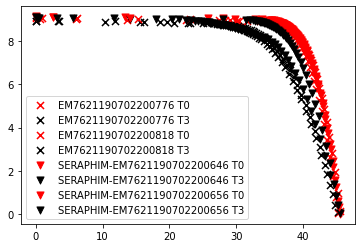

In [15]:
import matplotlib.pyplot as plt
# Get dataframe describing the experimental files
df_files_descp = pv.sqlite_to_dataframe(data_folder,pv.DATA_BASE_TABLE_FILE)   

# Select the module types which names has to be corrected
list_mod_selected = pv.build_modules_list(df_files_descp,data_folder)
iv_curve = {pv.parse_filename(file): pv.read_flashtest_file(file).IV0 
            for file in pv.build_modules_filenames(list_mod_selected,data_folder)}

colors = {'T0':'r','T3':'k'}
markers = {'EM7621190702200776':'x',
           'EM7621190702200818':'x',
           'SERAPHIM-EM7621190702200646':'v',
           'SERAPHIM-EM7621190702200656':'v'}

for name,value in iv_curve.items():
    plt.scatter(value["Voltage"][::70],
                value["Current"][::70],
                s=50,
                label=f'{name.module_type} {name.treatment}',
                c=colors[name.treatment],
                marker=markers[name.module_type],
                alpha=1)
    
plt.legend()

In [ ]:
from importlib import metadata
metadata.version('pip')
[p for p in metadata.files('PVcharacterization_Utils') if p.suffix=='.py']

In [ ]:
metadata.requires('PVcharacterization_Utils')